In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import dataiku
from dataiku import pandasutils as pdu
import pandas as pd
import numpy as np

import datetime as dt
from dateutil import relativedelta
import matplotlib.pyplot as plt

import matplotlib.ticker as mticker
import matplotlib.pylab as pl

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Data
mydataset = dataiku.Dataset("BMO_Mortgage_HELOC")
df = mydataset.get_dataframe()

mydataset = dataiku.Dataset("BMO_Mortgage_Q")
dfq = mydataset.get_dataframe()
dfq =dfq.dropna()

mydataset = dataiku.Dataset("Base")
base = mydataset.get_dataframe()

mydataset = dataiku.Dataset("Adverse")
adverse = mydataset.get_dataframe()

mydataset = dataiku.Dataset("Severe")
severe = mydataset.get_dataframe()

In [4]:
#replace NA with zero
df = df.replace(np.nan, 0)

In [5]:
#Dete time
df['datetime'] = pd.to_datetime(df['Date'])
dfq['datetime'] = pd.to_datetime(dfq['Date'])
base['datetime'] = pd.to_datetime(base['Date'])
adverse['datetime'] = pd.to_datetime(adverse['Date'])
severe['datetime'] = pd.to_datetime(severe['Date'])

In [6]:
#Total 
df['NR_Fixed'] = df['NR_Fixed_6']+df['NR_Fixed_12']+df['NR_Fixed_24']+df['NR_Fixed_36']+df['NR_Fixed_48']+df['NR_Fixed_60']+df['NR_Fixed_72']+df['NR_Fixed_84']+df['NR_Fixed_120']
df['NR_Var'] = df['NR_Var_6']+df['NR_Var_12']+df['NR_Var_24']+df['NR_Var_36']+df['NR_Var_48']+df['NR_Var_60']+df['NR_Var_72']+df['NR_Var_84']+df['NR_Var_120']

df['Resi_Fixed'] = df['Resi_Fixed_6']+df['Resi_Fixed_12']+df['Resi_Fixed_24']+df['Resi_Fixed_36']+df['Resi_Fixed_48']+df['Resi_Fixed_60']+df['Resi_Fixed_72']+df['Resi_Fixed_84']+df['Resi_Fixed_120']
df['Resi_Var'] = df['Resi_Var_6']+df['Resi_Var_12']+df['Resi_Var_24']+df['Resi_Var_36']+df['Resi_Var_48']+df['Resi_Var_60']+df['Resi_Var_72']+df['Resi_Var_84']+df['Resi_Var_120']

df['HELOC_Ins'] = df['Fixed_Install_HELOC'] + df['Var_Install_HELOC'] 

df['NonResi'] = df['NR_Fixed']+ df['NR_Var']
df['Resi'] = df['Resi_Fixed'] +df['Resi_Var'] 
df['Total'] =df['Resi'] + df['HELOC_Ins'] #excluding +df['NonResi']  
df['Resi_60'] = df['Resi_Fixed_60'] +df['Resi_Var_60'] 

In [7]:
#Format Y-axis
def y_fmt(tick_val, pos):
    if tick_val >= 100000000000:
        val = float(tick_val)/1000000000000
        return '{0:.1f} T'.format(val)
    else:
        val = float(tick_val)/1000000000
        return '{0:.1f} B'.format(val)


def y_bil(tick_val, pos):
    val = float(tick_val)/1000000000
    return '{0:.1f} B'.format(val)


#CAGR Function (annualized, from quarterly)
def CAGR(first, last, periods):
    return (float(last/first)**(1.0/periods)-1)

def month_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d") 
    return abs((d2 - d1).months)

In [8]:
df.head()

,Date,NR_Fixed_6,NR_Fixed_12,NR_Fixed_24,NR_Fixed_36,NR_Fixed_48,NR_Fixed_60,NR_Fixed_72,NR_Fixed_84,NR_Fixed_120,NR_Var_6,NR_Var_12,NR_Var_24,NR_Var_36,NR_Var_48,NR_Var_60,NR_Var_72,NR_Var_84,NR_Var_120,Resi_Fixed_6,Resi_Fixed_12,Resi_Fixed_24,Resi_Fixed_36,Resi_Fixed_48,Resi_Fixed_60,Resi_Fixed_72,Resi_Fixed_84,Resi_Fixed_120,Resi_Var_6,Resi_Var_12,Resi_Var_24,Resi_Var_36,Resi_Var_48,Resi_Var_60,Resi_Var_72,Resi_Var_84,Resi_Var_120,Fixed_Install_HELOC,Var_Install_HELOC,Var_Revolving_HELOC,datetime,NR_Fixed,NR_Var,Resi_Fixed,Resi_Var,HELOC_Ins,NonResi,Resi,Total,Resi_60
0,1/1/01,20755548.13,3.014602e+08,69743136.32,1.305083e+08,67788534.90,1.295511e+09,0.0,60758851.90,1.422247e+08,0,60022264.85,0,655414.36,0,466895.85,0.0,0,0,1.282332e+09,3.939812e+09,1.526356e+09,3.752221e+09,1.324505e+09,2.324684e+10,0.0,1.057515e+09,1.459231e+09,0,1233099.29,0,5.394432e+08,77068662.65,35208910.79,9.503344e+08,0.0,0,0.0,0.0,0.0,2001-01-01,2.088750e+09,61144575.06,3.758881e+10,1.603288e+09,0.0,2.149895e+09,3.919210e+10,3.919210e+10,2.328205e+10
1,2/1/01,20948271.04,3.038827e+08,63771840.71,1.281908e+08,65557995.85,1.292537e+09,0.0,60564618.12,1.413674e+08,0,62161753.81,0,653527.46,0,464915.09,0.0,0,0,1.266569e+09,3.903185e+09,1.521139e+09,3.704599e+09,1.246140e+09,2.316479e+10,0.0,1.039278e+09,1.457103e+09,0,1507797.73,0,5.917118e+08,74490296.91,35325136.92,1.053474e+09,0.0,0,0.0,0.0,0.0,2001-02-01,2.076821e+09,63280196.36,3.730281e+10,1.756509e+09,0.0,2.140101e+09,3.905932e+10,3.905932e+10,2.320012e+10
2,3/1/01,18752355.69,3.125460e+08,63498097.76,1.232464e+08,66876356.16,1.287890e+09,0.0,59963409.85,1.419255e+08,0,66142189.27,0,832575.37,0,418324.08,0.0,0,0,1.275919e+09,3.868189e+09,1.516544e+09,3.677199e+09,1.206787e+09,2.299223e+10,0.0,1.044036e+09,1.461167e+09,0,971475.87,0,6.506785e+08,71992847.06,34742147.03,1.196597e+09,0.0,0,0.0,0.0,0.0,2001-03-01,2.074698e+09,67393088.72,3.704208e+10,1.954982e+09,0.0,2.142091e+09,3.899706e+10,3.899706e+10,2.302698e+10
3,4/1/01,13877336.69,3.097958e+08,64710294.02,1.313517e+08,66343544.84,1.296072e+09,0.0,60668599.43,1.416932e+08,0,66725061.58,0,1092996.62,0,376304.91,0.0,0,0,1.274764e+09,3.715849e+09,1.494031e+09,3.656012e+09,1.157033e+09,2.267383e+10,0.0,1.405200e+09,1.533556e+09,0,961355.43,0,7.113686e+08,68940868.75,34443182.36,1.336280e+09,0.0,0,0.0,0.0,0.0,2001-04-01,2.084512e+09,68194363.11,3.691028e+10,2.151994e+09,0.0,2.152707e+09,3.906227e+10,3.906227e+10,2.270828e+10
4,5/1/01,22080290.30,3.064064e+08,63537761.29,1.322630e+08,65783049.21,1.292901e+09,0.0,60969601.18,1.429347e+08,0,69619706.32,0,1084890.08,0,378781.97,0.0,0,0,1.231641e+09,3.603705e+09,1.467528e+09,3.629534e+09,1.112858e+09,2.236763e+10,0.0,1.931021e+09,1.622582e+09,0,959546.67,0,7.493721e+08,66187170.87,33658596.81,1.443775e+09,0.0,0,0.0,0.0,0.0,2001-05-01,2.086876e+09,71083378.37,3.696650e+10,2.293952e+09,0.0,2.157959e+09,3.926045e+10,3.926045e+10,2.240129e+10


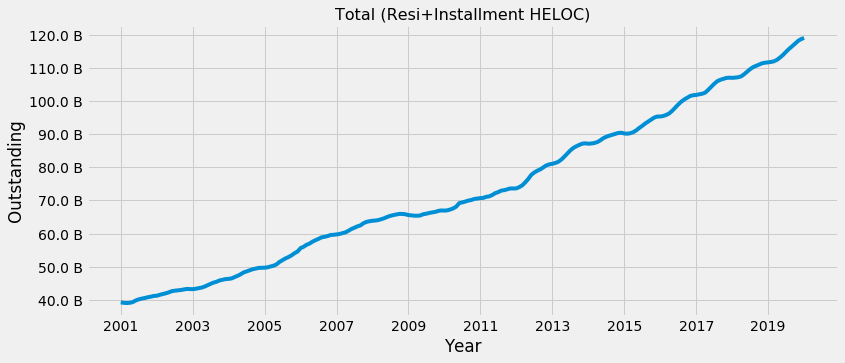

In [9]:
#Total Resi
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(1, 1, figsize=(12,5))


ax.plot('datetime', 'Total', data=df)
ax.set_title('Total (Resi+Installment HELOC)', fontsize=16)

#Format y-axis
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
#g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(y_bil))

plt.xlabel('Year')
plt.ylabel('Outstanding')

plt.show()


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels,loc='upper left', prop={"size":12}) 

#show CARGs
#ax1.text(9, b_end, '9qtr CAGR of {:.2%} '.format(b_cagr), fontsize=14, va='top')

['Total', 'Resi', 'HELOC_Ins']


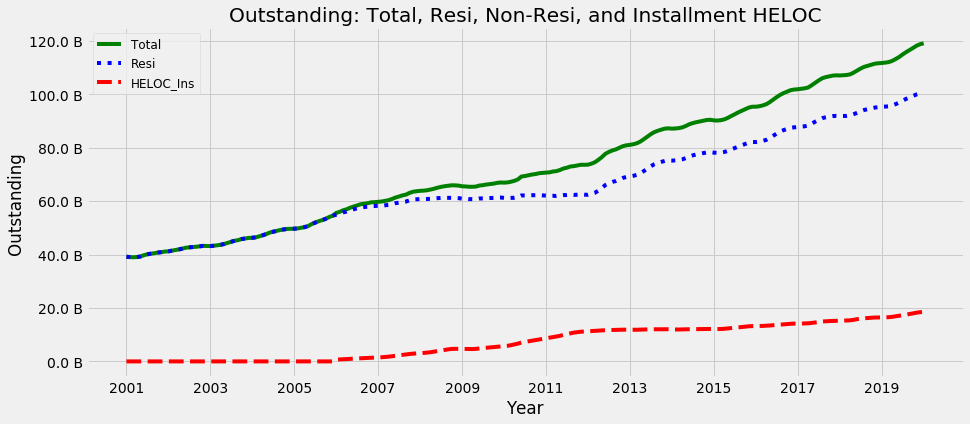

In [10]:
#Total, Resi, and Non-Resi
plt_df = df[['Total', 'Resi', 'HELOC_Ins', 'datetime']]

cols = [col for col in plt_df.columns][0:3]
print(cols)

fig, ax = plt.subplots(1, 1, figsize=(14,6))

plt.style.use('fivethirtyeight')
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(y_bil))

colors = ['g', 'b:', '--r']

i=0
for c in cols:
    i = i +1 
    plt.figure
    ax.plot('datetime', c,  colors[(i-1)], data=plt_df)
    ax.set_title('Outstanding: Total, Resi, Non-Resi, and Installment HELOC')
    
    plt.xlabel('Year')
    plt.ylabel('Outstanding')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels,loc='upper left', prop={"size":12})

plt.show()

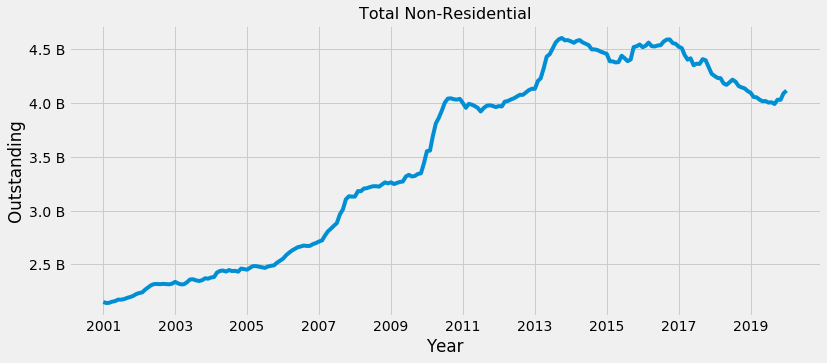

In [11]:
#Total Non-Resi
fig, ax = plt.subplots(1, 1, figsize=(12,5))

plt.style.use('fivethirtyeight')

f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(y_fmt))


ax.plot('datetime', 'NonResi', data=df)
ax.set_title('Total Non-Residential', fontsize=16)

#plt.yticks(np.arange(df['NonResi'].min(), df['NonResi'].max()))

plt.xlabel('Year')
plt.ylabel('Outstanding')

plt.show()

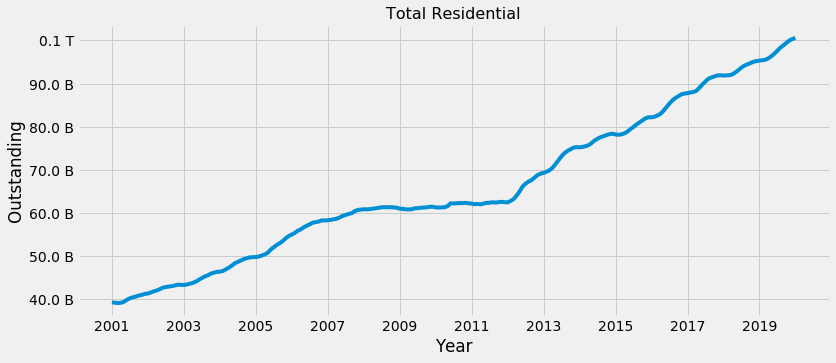

In [12]:
#Total Resi
fig, ax = plt.subplots(1, 1, figsize=(12,5))

plt.style.use('fivethirtyeight')
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(y_fmt))

ax.plot('datetime', 'Resi', data=df)
ax.set_title('Total Residential', fontsize=16)

#plt.yticks(np.arange(df['Resi'].min()-0.9e10, df['Resi'].max(), 5e9))

plt.xlabel('Year')
plt.ylabel('Outstanding')

plt.show()

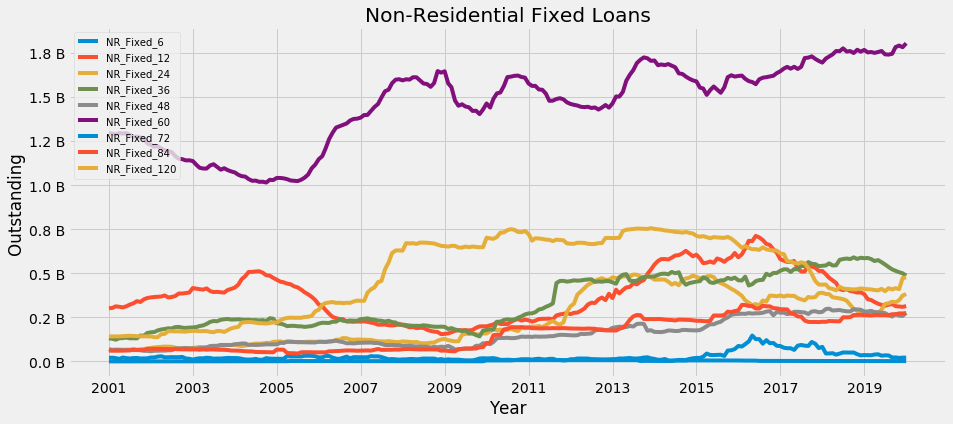

In [13]:
#Non-Residential Fixed Loans
nr_fixed_cols = [col for col in df.columns if 'NR_Fixed' in col][0:9]

fig, ax = plt.subplots(1, 1, figsize=(14,6))

plt.style.use('fivethirtyeight')
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(y_fmt))

for c in nr_fixed_cols:
    plt.figure
    ax.plot('datetime', c, data=df)
    ax.set_title('Non-Residential Fixed Loans')
    plt.xlabel('Year')
    plt.ylabel('Outstanding')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels,loc='upper left', prop={"size":10})
    
plt.show()

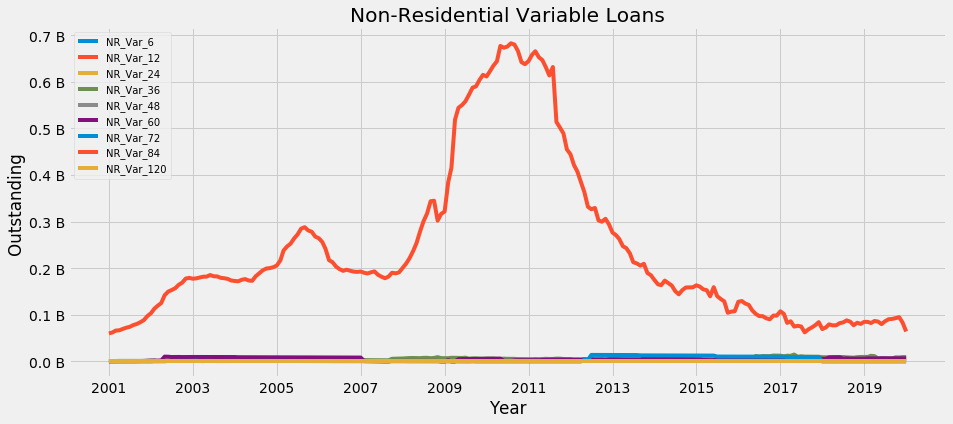

In [14]:
#Non-Residential Variable Loans
nr_var_cols = [col for col in df.columns if 'NR_Var' in col][0:9]

fig, ax = plt.subplots(1, 1, figsize=(14,6))

plt.style.use('fivethirtyeight')
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(y_fmt))

for c in nr_var_cols:
    plt.figure
    ax.plot('datetime', c, data=df)
    ax.set_title('Non-Residential Variable Loans')
    plt.xlabel('Year')
    plt.ylabel('Outstanding')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels,loc='upper left', prop={"size":10})
    
plt.show()

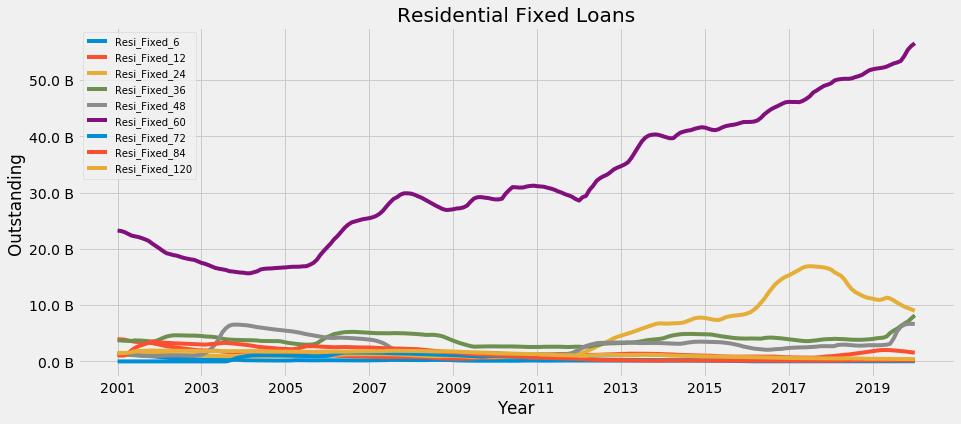

In [15]:
#Residential Fixed Loans
resi_fixed_cols = [col for col in df.columns if 'Resi_Fixed' in col][0:9]

fig, ax = plt.subplots(1, 1, figsize=(14,6))

plt.style.use('fivethirtyeight')
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(y_fmt))

for c in resi_fixed_cols:
    plt.figure
    ax.plot('datetime', c, data=df)
    ax.set_title('Residential Fixed Loans')
    plt.xlabel('Year')
    plt.ylabel('Outstanding')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels,loc='upper left', prop={"size":10})
    
plt.show()

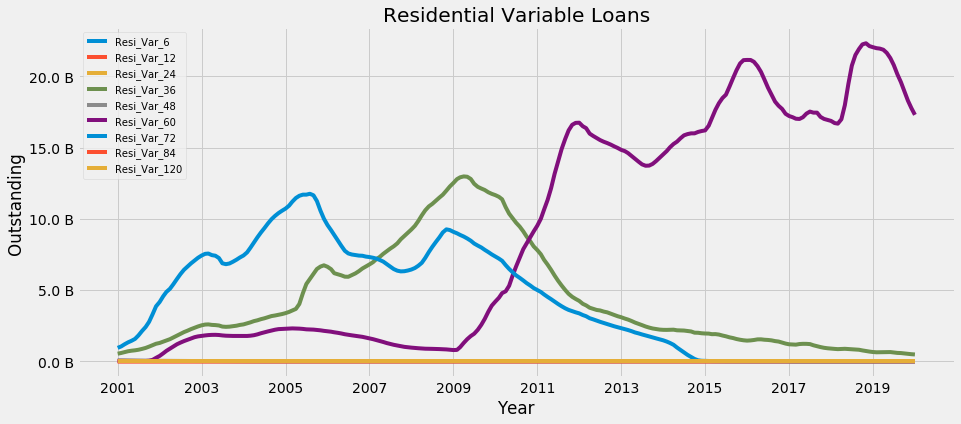

In [16]:
#Residential Variable Loans
resi_var_cols = [col for col in df.columns if 'Resi_Var' in col][0:9]

fig, ax = plt.subplots(1, 1, figsize=(14,6))

plt.style.use('fivethirtyeight')
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(y_fmt))

for c in resi_var_cols:
    plt.figure
    ax.plot('datetime', c, data=df)
    ax.set_title('Residential Variable Loans')
    plt.xlabel('Year')
    plt.ylabel('Outstanding')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels,loc='upper left', prop={"size":10})
    
plt.show()

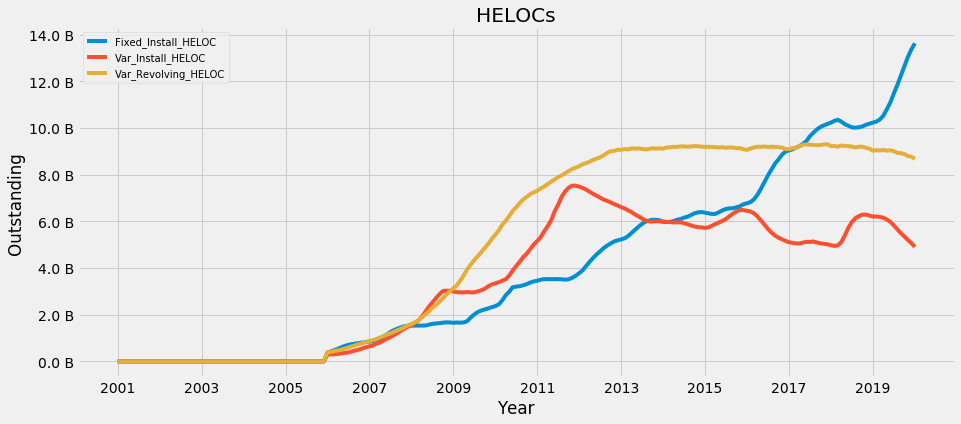

In [17]:
#HELOC Installment
resi_var_cols = [col for col in df.columns if 'HELOC' in col][0:3]

fig, ax = plt.subplots(1, 1, figsize=(14,6))

plt.style.use('fivethirtyeight')
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(y_fmt))

for c in resi_var_cols:
    plt.figure
    ax.plot('datetime', c, data=df)
    ax.set_title('HELOCs')
    plt.xlabel('Year')
    plt.ylabel('Outstanding')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels,loc='upper left', prop={"size":10})
    
plt.show()

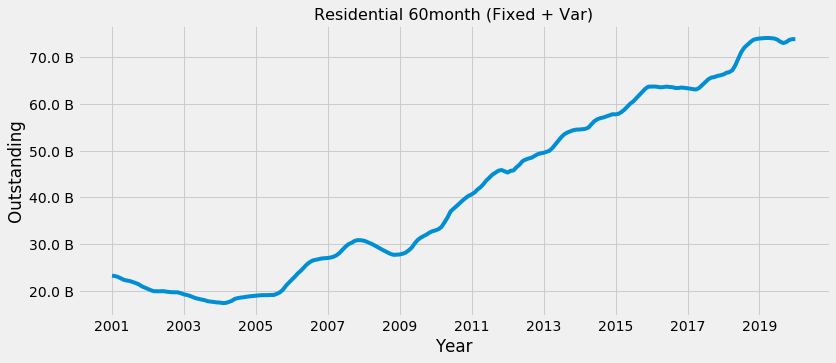

In [18]:
#Resi Fixed and Resi Variable 60month
fig, ax = plt.subplots(1, 1, figsize=(12,5))

plt.style.use('fivethirtyeight')
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(y_fmt))

ax.plot('datetime', 'Resi_60', data=df)
ax.set_title('Residential 60month (Fixed + Var)', fontsize=16)

plt.xlabel('Year')
plt.ylabel('Outstanding')

plt.show()

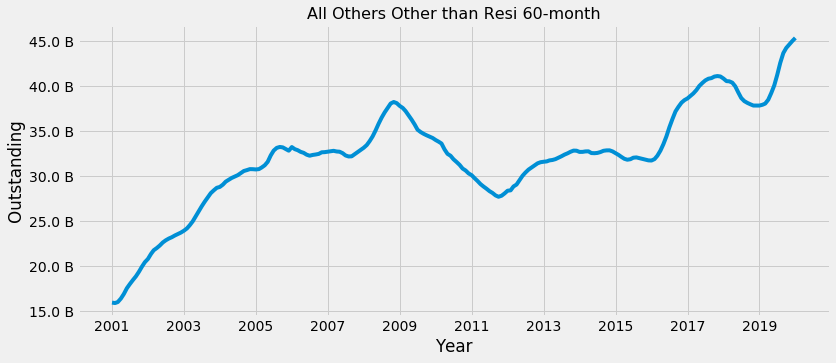

In [19]:
#All Others other than Resi 60 month
fig, ax = plt.subplots(1, 1, figsize=(12,5))

plt.style.use('fivethirtyeight')
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(y_fmt))

df['all_others'] = df['Total'] - df['Resi_60']
ax.plot('datetime', 'all_others', data=df)
ax.set_title('All Others Other than Resi 60-month', fontsize=16)

plt.xlabel('Year')
plt.ylabel('Outstanding')

plt.show()

['Total', 'Resi_60', 'all_others']


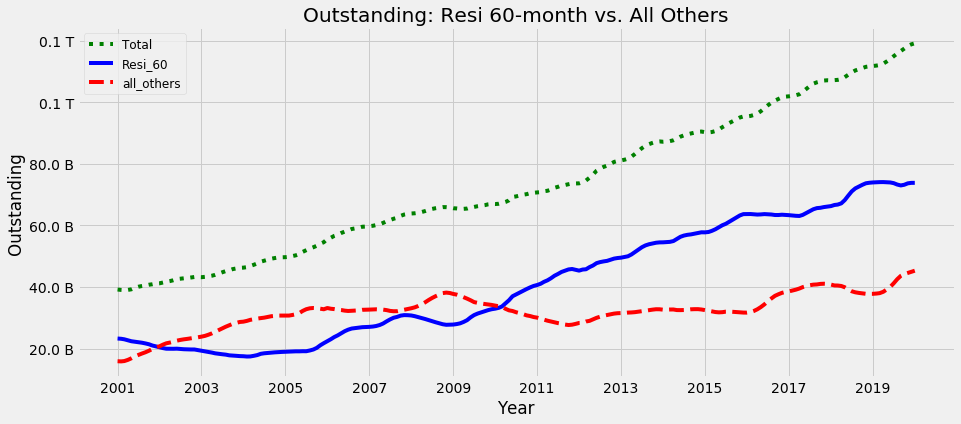

In [20]:
#Residential Variable Loans
plt_df = df[['Total', 'Resi_60', 'all_others', 'datetime']]

cols = [col for col in plt_df.columns][0:3]
print(cols)

fig, ax = plt.subplots(1, 1, figsize=(14,6))

plt.style.use('fivethirtyeight')
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(y_fmt))

colors = ['g:', 'b', 'r--']

i=0
for c in cols:
    i = i +1 
    plt.figure
    ax.plot('datetime', c,  colors[(i-1)], data=plt_df)
    ax.set_title('Outstanding: Resi 60-month vs. All Others')
    
    plt.xlabel('Year')
    plt.ylabel('Outstanding')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels,loc='upper left', prop={"size":12})

plt.show()

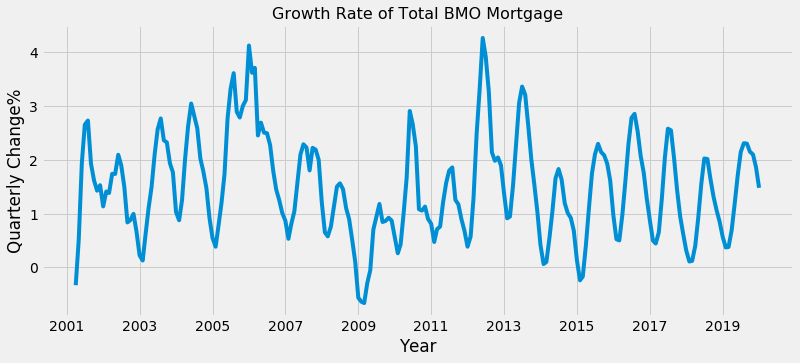

In [21]:
#Calculate growth rates and plot 
df['BMO_Mort_growth']=(df['Total'].pct_change(3))*100

fig, ax = plt.subplots(1, 1, figsize=(12,5))

plt.style.use('fivethirtyeight')
#f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
#plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(y_fmt))

ax.plot('datetime', 'BMO_Mort_growth', data=df)
ax.set_title('Growth Rate of Total BMO Mortgage', fontsize=16)

plt.xlabel('Year')
plt.ylabel('Quarterly Change%')

plt.show()

In [22]:
#Macro vs. Residential Loans (Resi 5yr vs. 5yr)
base_df =  pd.merge(base, df, on='datetime', how='inner')
#base_df = pd.concat([df, base]).sort_values('datetime').reset_index(drop=True)
base_df.index = base_df['datetime']

In [23]:
base_df.head()

,Date_x,NGDP,RealGDP,Unemp,CPI,CP,PolicyRate,RealPolicy,Prime,G1m,G3m,G6m,G12m,G2y,G3y,G5y,G7y,G10y,Debt_Income,HPI,HPI_Toronto,HPI_Montreal,HPI_Alberta,HPI_Calgary,HPI_Vancouver,Mort5yr,Bond5yr,G5_G2,G5_G1m,G5_G6m,G5_G12m,lag_1_NGDP,lag_2_NGDP,nat_log_NGDP,lag_1_nat_log_NGDP,nat_logRatio_NGDP,qoq_p_NGDP,qoq_p_lag1_NGDP,qoq_p_lag2_NGDP,qoq_p_lag3_NGDP,qt_qt2_NGDP,qoq_d_NGDP,qoq_d_lag1_NGDP,qoq_d_lag2_NGDP,qoq_d_lag3_NGDP,qoq_log_ratio_NGDP,qoq_ann_NGDP,qoq_ann_lag3_NGDP,yoy_p_NGDP,yoy_p_lag1_NGDP,yoy_d_NGDP,lag_1_RealGDP,lag_2_RealGDP,nat_log_RealGDP,lag_1_nat_log_RealGDP,nat_logRatio_RealGDP,qoq_p_RealGDP,qoq_p_lag1_RealGDP,qoq_p_lag2_RealGDP,qoq_p_lag3_RealGDP,qt_qt2_RealGDP,qoq_d_RealGDP,qoq_d_lag1_RealGDP,qoq_d_lag2_RealGDP,qoq_d_lag3_RealGDP,qoq_log_ratio_RealGDP,qoq_ann_RealGDP,qoq_ann_lag3_RealGDP,yoy_p_RealGDP,yoy_p_lag1_RealGDP,yoy_d_RealGDP,lag_1_Unemp,lag_2_Unemp,nat_log_Unemp,lag_1_nat_log_Unemp,nat_logRatio_Unemp,qoq_p_Unemp,qoq_p_lag1_Unemp,qoq_p_lag2_Unemp,qoq_p_lag3_Unemp,qt_qt2_Unemp,qoq_d_Unemp,qoq_d_lag1_Unemp,qoq_d_lag2_Unemp,qoq_d_lag3_Unemp,qoq_log_ratio_Unemp,qoq_ann_Unemp,qoq_ann_lag3_Unemp,yoy_p_Unemp,yoy_p_lag1_Unemp,yoy_d_Unemp,lag_1_SP500,SP500,lag_2_SP500,nat_log_SP500,lag_1_nat_log_SP500,nat_logRatio_SP500,qoq_p_SP500,qoq_p_lag1_SP500,qoq_p_lag2_SP500,qoq_p_lag3_SP500,qt_qt2_SP500,qoq_d_SP500,qoq_d_lag1_SP500,qoq_d_lag2_SP500,...,qoq_p_lag2_G5_G1m,qoq_p_lag3_G5_G1m,qt_qt2_G5_G1m,qoq_d_G5_G1m,qoq_d_lag1_G5_G1m,qoq_d_lag2_G5_G1m,qoq_d_lag3_G5_G1m,qoq_log_ratio_G5_G1m,qoq_ann_G5_G1m,qoq_ann_lag3_G5_G1m,yoy_p_G5_G1m,yoy_p_lag1_G5_G1m,yoy_d_G5_G1m,lag_1_G5_G6m,lag_2_G5_G6m,nat_log_G5_G6m,lag_1_nat_log_G5_G6m,nat_logRatio_G5_G6m,qoq_p_G5_G6m,qoq_p_lag1_G5_G6m,qoq_p_lag2_G5_G6m,qoq_p_lag3_G5_G6m,qt_qt2_G5_G6m,qoq_d_G5_G6m,qoq_d_lag1_G5_G6m,qoq_d_lag2_G5_G6m,qoq_d_lag3_G5_G6m,qoq_log_ratio_G5_G6m,qoq_ann_G5_G6m,qoq_ann_lag3_G5_G6m,yoy_p_G5_G6m,yoy_p_lag1_G5_G6m,yoy_d_G5_G6m,lag_1_G5_G12m,lag_2_G5_G12m,nat_log_G5_G12m,lag_1_nat_log_G5_G12m,nat_logRatio_G5_G12m,qoq_p_G5_G12m,qoq_p_lag1_G5_G12m,qoq_p_lag2_G5_G12m,qoq_p_lag3_G5_G12m,qt_qt2_G5_G12m,qoq_d_G5_G12m,qoq_d_lag1_G5_G12m,qoq_d_lag2_G5_G12m,qoq_d_lag3_G5_G12m,qoq_log_ratio_G5_G12m,qoq_ann_G5_G12m,qoq_ann_lag3_G5_G12m,yoy_p_G5_G12m,yoy_p_lag1_G5_G12m,yoy_d_G5_G12m,datetime,Date_y,NR_Fixed_6,NR_Fixed_12,NR_Fixed_24,NR_Fixed_36,NR_Fixed_48,NR_Fixed_60,NR_Fixed_72,NR_Fixed_84,NR_Fixed_120,NR_Var_6,NR_Var_12,NR_Var_24,NR_Var_36,NR_Var_48,NR_Var_60,NR_Var_72,NR_Var_84,NR_Var_120,Resi_Fixed_6,Resi_Fixed_12,Resi_Fixed_24,Resi_Fixed_36,Resi_Fixed_48,Resi_Fixed_60,Resi_Fixed_72,Resi_Fixed_84,Resi_Fixed_120,Resi_Var_6,Resi_Var_12,Resi_Var_24,Resi_Var_36,Resi_Var_48,Resi_Var_60,Resi_Var_72,Resi_Var_84,Resi_Var_120,Fixed_Install_HELOC,Var_Install_HELOC,Var_Revolving_HELOC,NR_Fixed,NR_Var,Resi_Fixed,Resi_Var,HELOC_Ins,NonResi,Resi,Total,Resi_60,all_others,BMO_Mort_growth
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-03-01,3/1/01,1.149930e+06,1468700.0,7.005834,96.850023,85784.790257,5.333333,3.543243,7.083333,5.045455,4.977333,4.876667,4.840000,4.870970,4.980000,5.127591,5.213333,5.383333,106.12,166598.0,244900.0,127436.0,149358.0,179146.0,286505.0,7.19,4.98,0.256621,0.082136,0.250924,0.287591,1.132885e+06,1.121775e+06,13.955212,13.940278,0.014934,0.015046,0.009904,0.020291,0.027346,28155.176452,17045.071791,11110.104661,22309.562376,29266.132331,0.014934,0.061555,0.113955,0.074501,NaN,79730.871159,1460962.0,1458465.0,14.199888,14.194606,0.005283,0.005297,0.001712,0.010170,0.011886,10235.0,7738.0,2497.0,14683.0,16959.0,0.005283,0.021355,0.048398,0.029350,NaN,41877.0,6.913413,6.899222,1.946743,1.933463,0.013280,0.013368,0.002057,0.030217,-0.020718,0.106612,0.092421,0.014191,0.202356,-0.141681,0.013280,0.054556,-0.080332,0.024462,NaN,0.167287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [24]:
#Compare to US experience
mydataset = dataiku.Dataset("US_BMO_Mort_bal_to_dataiku")
us_df = mydataset.get_dataframe()
us_df =us_df.dropna()

#Dete time
us_df['datetime'] = pd.to_datetime(us_df['Date'])


['BMO_Mort_growth', u'qoq_p_NGDP']


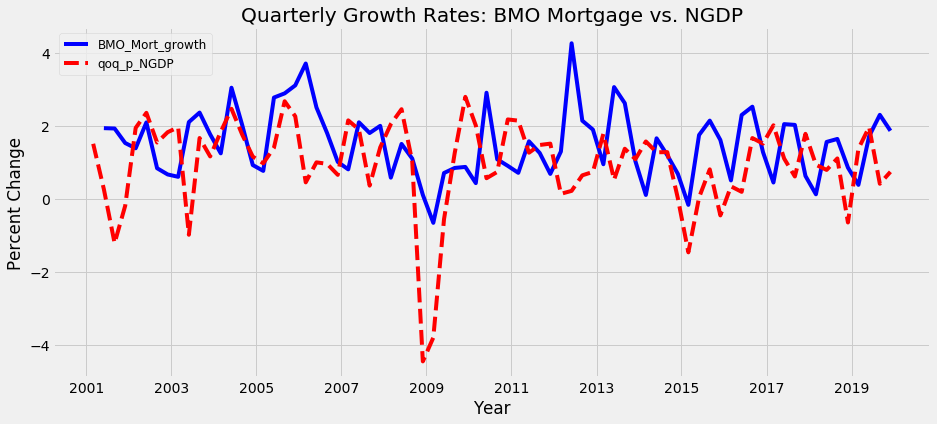

In [25]:
#Resi vs. GDP
plt_df = base_df[['BMO_Mort_growth', 'qoq_p_NGDP', 'datetime']]
plt_df['qoq_p_NGDP'] = plt_df['qoq_p_NGDP']*100


cols = [col for col in plt_df.columns][0:2]
print(cols)

fig, ax = plt.subplots(1, 1, figsize=(14,6))

plt.style.use('fivethirtyeight')

colors = ['b', 'r--']

i=0
for c in cols:
    i = i +1 
    plt.figure
    ax.plot('datetime', c,  colors[(i-1)], data=plt_df)
    ax.set_title('Quarterly Growth Rates: BMO Mortgage vs. NGDP')
    plt.xlabel('Year')
    plt.ylabel('Percent Change')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels,loc='upper left', prop={"size":12})

    
plt.show()

['BMO_Mort_growth', u'qoq_d_Unemp']


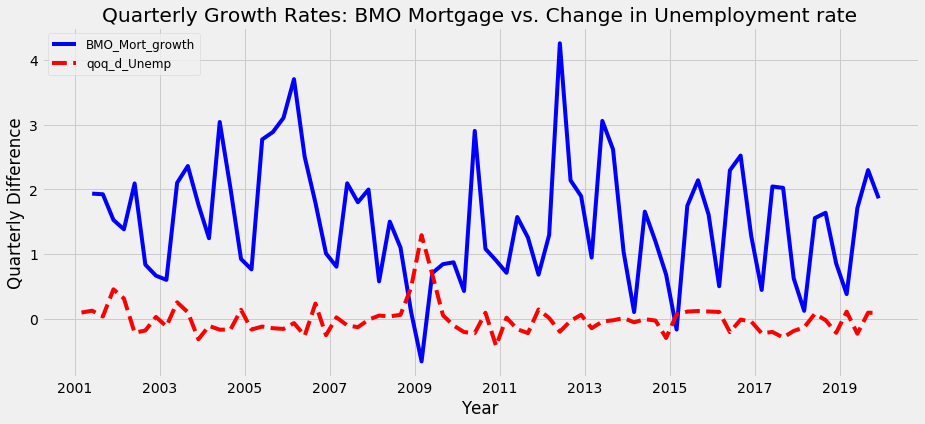

In [26]:
#Resi vs. Unemp
plt_df = base_df[['BMO_Mort_growth', 'qoq_d_Unemp', 'datetime']]
plt_df['qoq_d_Unemp'] = plt_df['qoq_d_Unemp']


cols = [col for col in plt_df.columns][0:2]
print(cols)

fig, ax = plt.subplots(1, 1, figsize=(14,6))

plt.style.use('fivethirtyeight')

colors = ['b', 'r--']

i=0
for c in cols:
    i = i +1 
    plt.figure
    ax.plot('datetime', c,  colors[(i-1)], data=plt_df)
    ax.set_title('Quarterly Growth Rates: BMO Mortgage vs. Change in Unemployment rate')
    plt.xlabel('Year')
    plt.ylabel('Quarterly Difference')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels,loc='upper left', prop={"size":12})

    
plt.show()

Correlation

['BMO_Mort_growth', u'qoq_p_HPI']


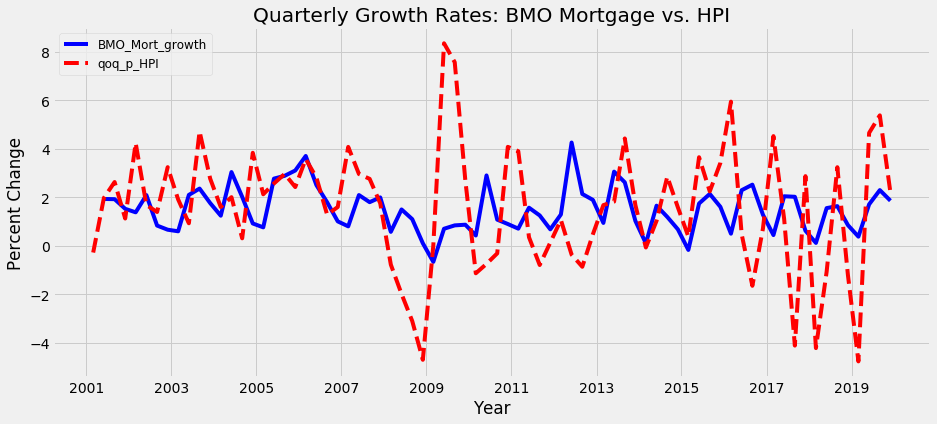

In [27]:
#Resi vs. HPI
plt_df = base_df[['BMO_Mort_growth', 'qoq_p_HPI', 'datetime']]
plt_df['qoq_p_HPI'] = plt_df['qoq_p_HPI']*100


cols = [col for col in plt_df.columns][0:2]
print(cols)

fig, ax = plt.subplots(1, 1, figsize=(14,6))

plt.style.use('fivethirtyeight')

colors = ['b', 'r--']

i=0
for c in cols:
    i = i +1 
    plt.figure
    ax.plot('datetime', c,  colors[(i-1)], data=plt_df)
    ax.set_title('Quarterly Growth Rates: BMO Mortgage vs. HPI')
    plt.xlabel('Year')
    plt.ylabel('Percent Change')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels,loc='upper left', prop={"size":12})

    
plt.show()

['BMO_Mort_growth', u'yoy_p_HPI']


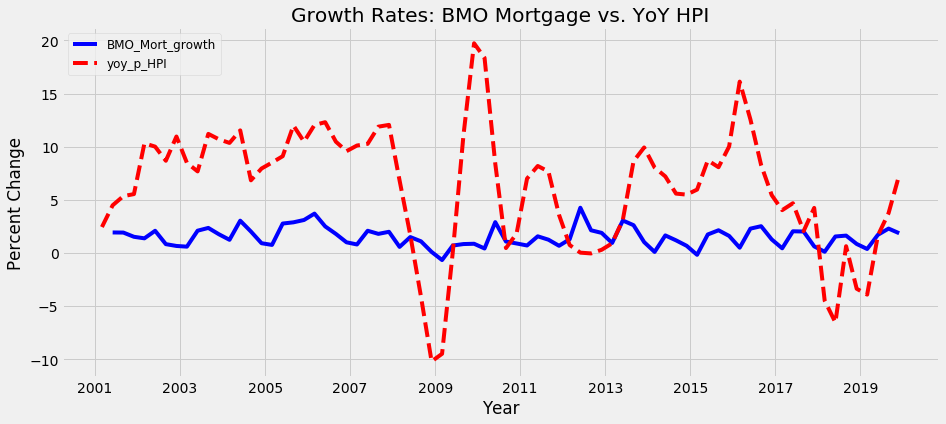

In [28]:
#Resi vs. HPI
plt_df = base_df[['BMO_Mort_growth', 'yoy_p_HPI', 'datetime']]
plt_df['yoy_p_HPI'] = plt_df['yoy_p_HPI']*100


cols = [col for col in plt_df.columns][0:2]
print(cols)

fig, ax = plt.subplots(1, 1, figsize=(14,6))

plt.style.use('fivethirtyeight')

colors = ['b', 'r--']

i=0
for c in cols:
    i = i +1 
    plt.figure
    ax.plot('datetime', c,  colors[(i-1)], data=plt_df)
    ax.set_title('Growth Rates: BMO Mortgage vs. YoY HPI')
    plt.xlabel('Year')
    plt.ylabel('Percent Change')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels,loc='upper left', prop={"size":12})

    
plt.show()

['BMO_Mort_growth', u'qoq_p_HPI_Toronto']


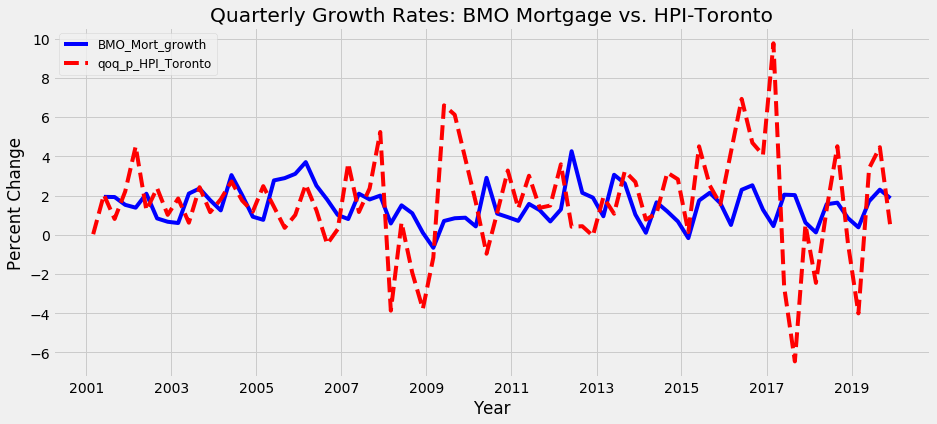

In [29]:
#HPI_Toronto
plt_df = base_df[['BMO_Mort_growth', 'qoq_p_HPI_Toronto', 'datetime']]
plt_df['qoq_p_HPI_Toronto'] = plt_df['qoq_p_HPI_Toronto']*100


cols = [col for col in plt_df.columns][0:2]
print(cols)

fig, ax = plt.subplots(1, 1, figsize=(14,6))

plt.style.use('fivethirtyeight')

colors = ['b', 'r--']

i=0
for c in cols:
    i = i +1 
    plt.figure
    ax.plot('datetime', c,  colors[(i-1)], data=plt_df)
    ax.set_title('Quarterly Growth Rates: BMO Mortgage vs. HPI-Toronto')
    plt.xlabel('Year')
    plt.ylabel('Percent Change')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels,loc='upper left', prop={"size":12})

    
plt.show()

['BMO_Mort_growth', u'qoq_p_HPI_Montreal']


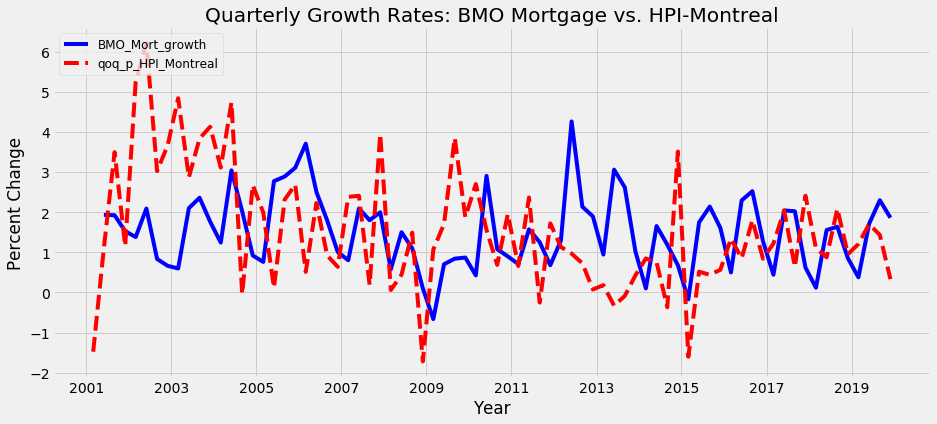

In [30]:
#HPI_Montreal
plt_df = base_df[['BMO_Mort_growth', 'qoq_p_HPI_Montreal', 'datetime']]
plt_df['qoq_p_HPI_Montreal'] = plt_df['qoq_p_HPI_Montreal']*100


cols = [col for col in plt_df.columns][0:2]
print(cols)

fig, ax = plt.subplots(1, 1, figsize=(14,6))

plt.style.use('fivethirtyeight')

colors = ['b', 'r--']

i=0
for c in cols:
    i = i +1 
    plt.figure
    ax.plot('datetime', c,  colors[(i-1)], data=plt_df)
    ax.set_title('Quarterly Growth Rates: BMO Mortgage vs. HPI-Montreal')
    plt.xlabel('Year')
    plt.ylabel('Percent Change')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels,loc='upper left', prop={"size":12})

    
plt.show()

['BMO_Mort_growth', u'qoq_p_HPI_Alberta']


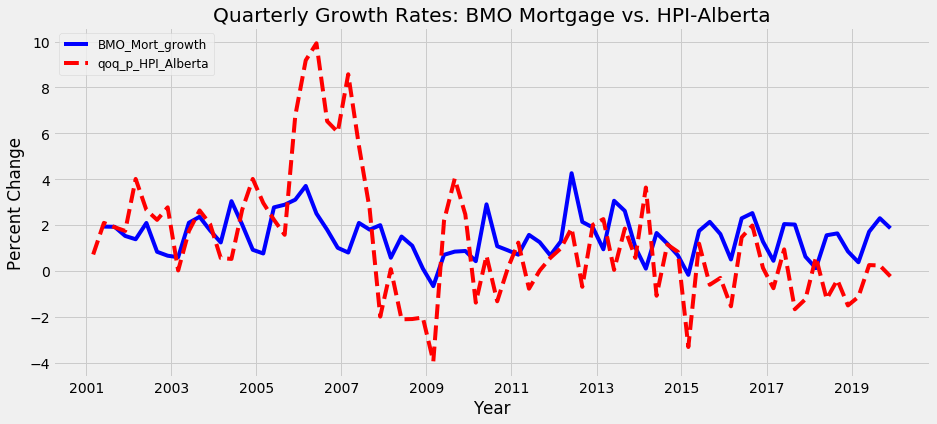

In [31]:
#HPI_Alberta
plt_df = base_df[['BMO_Mort_growth', 'qoq_p_HPI_Alberta', 'datetime']]
plt_df['qoq_p_HPI_Alberta'] = plt_df['qoq_p_HPI_Alberta']*100

cols = [col for col in plt_df.columns][0:2]
print(cols)

fig, ax = plt.subplots(1, 1, figsize=(14,6))

plt.style.use('fivethirtyeight')

colors = ['b', 'r--']

i=0
for c in cols:
    i = i +1 
    plt.figure
    ax.plot('datetime', c,  colors[(i-1)], data=plt_df)
    ax.set_title('Quarterly Growth Rates: BMO Mortgage vs. HPI-Alberta')
    plt.xlabel('Year')
    plt.ylabel('Percent Change')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels,loc='upper left', prop={"size":12})

    
plt.show()

['BMO_Mort_growth', u'qoq_p_HPI_Calgary']


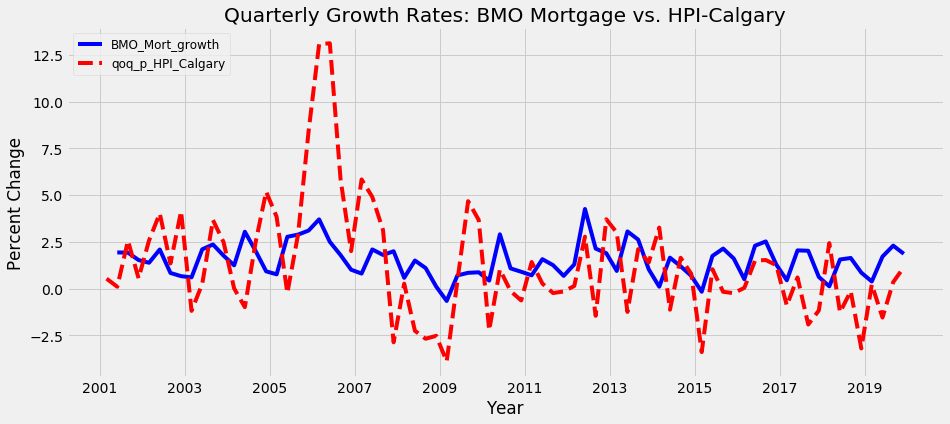

In [32]:
#HPI_Calgary
plt_df = base_df[['BMO_Mort_growth', 'qoq_p_HPI_Calgary', 'datetime']]
plt_df['qoq_p_HPI_Calgary'] = plt_df['qoq_p_HPI_Calgary']*100

cols = [col for col in plt_df.columns][0:2]
print(cols)

fig, ax = plt.subplots(1, 1, figsize=(14,6))

plt.style.use('fivethirtyeight')

colors = ['b', 'r--']

i=0
for c in cols:
    i = i +1 
    plt.figure
    ax.plot('datetime', c,  colors[(i-1)], data=plt_df)
    ax.set_title('Quarterly Growth Rates: BMO Mortgage vs. HPI-Calgary')
    plt.xlabel('Year')
    plt.ylabel('Percent Change')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels,loc='upper left', prop={"size":12})

    
plt.show()

['BMO_Mort_growth', u'qoq_p_HPI_Vancouver']


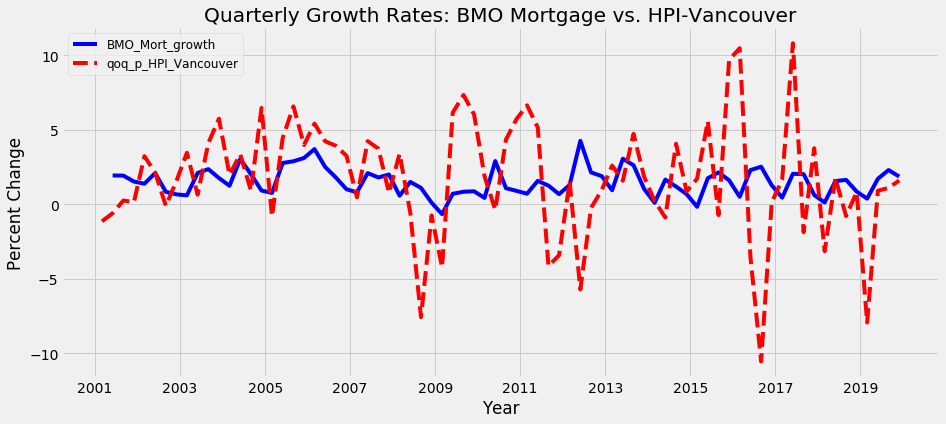

In [33]:
#HPI_Vancouver
plt_df = base_df[['BMO_Mort_growth', 'qoq_p_HPI_Vancouver', 'datetime']]
plt_df['qoq_p_HPI_Vancouver'] = plt_df['qoq_p_HPI_Vancouver']*100

cols = [col for col in plt_df.columns][0:2]
print(cols)

fig, ax = plt.subplots(1, 1, figsize=(14,6))

plt.style.use('fivethirtyeight')

colors = ['b', 'r--']

i=0
for c in cols:
    i = i +1 
    plt.figure
    ax.plot('datetime', c,  colors[(i-1)], data=plt_df)
    ax.set_title('Quarterly Growth Rates: BMO Mortgage vs. HPI-Vancouver')
    plt.xlabel('Year')
    plt.ylabel('Percent Change')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels,loc='upper left', prop={"size":12})

    
plt.show()

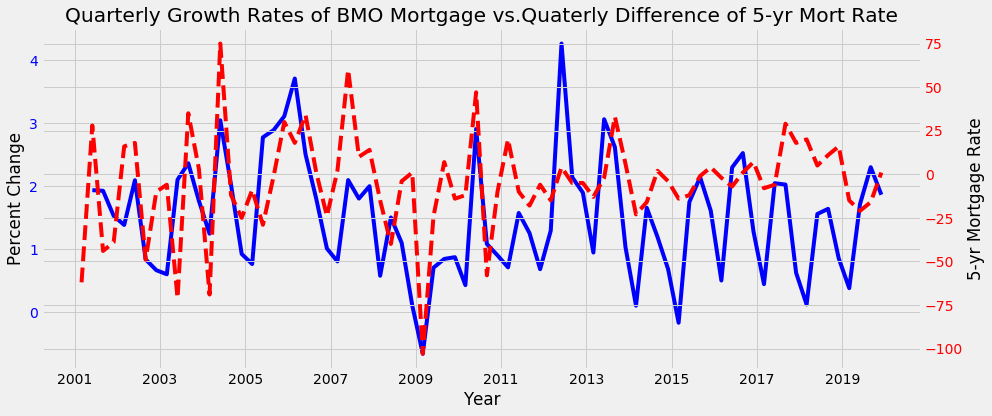

In [34]:
#5-yr Mortgage Rate
plt_df = base_df[['BMO_Mort_growth', 'qoq_d_Mort5yr', 'datetime']]
plt_df['qoq_d_Mort5yr'] = plt_df['qoq_d_Mort5yr']*100

fig, ax1 = plt.subplots(1, 1, figsize=(14,6))

plt.style.use('fivethirtyeight')

color = 'b'
ax1.set_xlabel('Year')
ax1.set_ylabel('Percent Change')
ax1.plot('datetime', 'BMO_Mort_growth', data =plt_df, color = color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Quarterly Growth Rates of BMO Mortgage vs.Quaterly Difference of 5-yr Mort Rate')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'r'
ax2.set_ylabel('5-yr Mortgage Rate')  # we already handled the x-label with ax1
ax2.plot('datetime','qoq_d_Mort5yr','--',  color = color,   data =plt_df)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

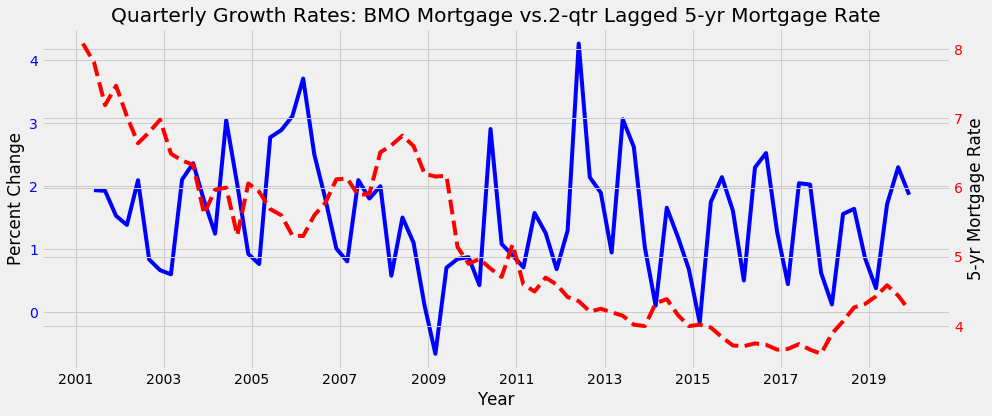

In [35]:
#5-yr Mortgage Rate
plt_df = base_df[['BMO_Mort_growth', 'lag_2_Mort5yr', 'datetime']]
plt_df['lag_2_Mort5yr'] = plt_df['lag_2_Mort5yr']

fig, ax1 = plt.subplots(1, 1, figsize=(14,6))

plt.style.use('fivethirtyeight')

color = 'b'
ax1.set_xlabel('Year')
ax1.set_ylabel('Percent Change')
ax1.plot('datetime', 'BMO_Mort_growth', data =plt_df, color = color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Quarterly Growth Rates: BMO Mortgage vs.2-qtr Lagged 5-yr Mortgage Rate')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'r'
ax2.set_ylabel('5-yr Mortgage Rate')  # we already handled the x-label with ax1
ax2.plot('datetime','lag_2_Mort5yr','--',  color = color,   data =plt_df)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

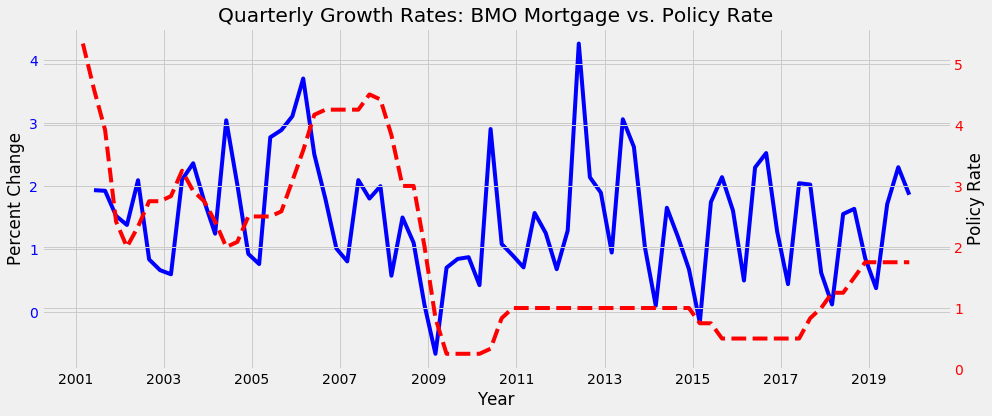

In [36]:
#Policy Rate
plt_df = base_df[['BMO_Mort_growth', 'PolicyRate', 'datetime']]
#plt_df['lag_2_Mort5yr'] = plt_df['lag_2_Mort5yr']

fig, ax1 = plt.subplots(1, 1, figsize=(14,6))

plt.style.use('fivethirtyeight')

color = 'b'
ax1.set_xlabel('Year')
ax1.set_ylabel('Percent Change')
ax1.plot('datetime', 'BMO_Mort_growth', data =plt_df, color = color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Quarterly Growth Rates: BMO Mortgage vs. Policy Rate')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'r'
ax2.set_ylabel('Policy Rate')  # we already handled the x-label with ax1
ax2.plot('datetime','PolicyRate','--',  color = color,   data =plt_df)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

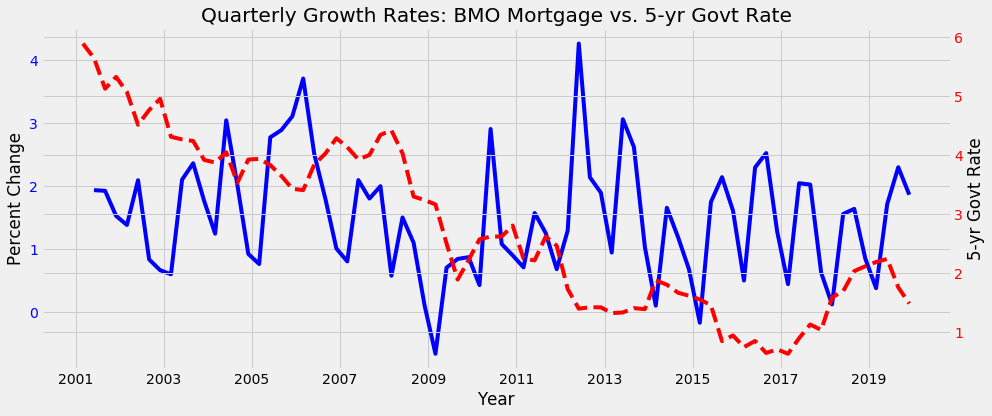

In [37]:
#5-yr Government Rate
plt_df = base_df[['BMO_Mort_growth', 'lag_2_G5y', 'datetime']]

fig, ax1 = plt.subplots(1, 1, figsize=(14,6))

plt.style.use('fivethirtyeight')

color = 'b'
ax1.set_xlabel('Year')
ax1.set_ylabel('Percent Change')
ax1.plot('datetime', 'BMO_Mort_growth', data =plt_df, color = color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Quarterly Growth Rates: BMO Mortgage vs. 5-yr Govt Rate')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'r'
ax2.set_ylabel('5-yr Govt Rate')  # we already handled the x-label with ax1
ax2.plot('datetime','lag_2_G5y','--',  color = color,   data =plt_df)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

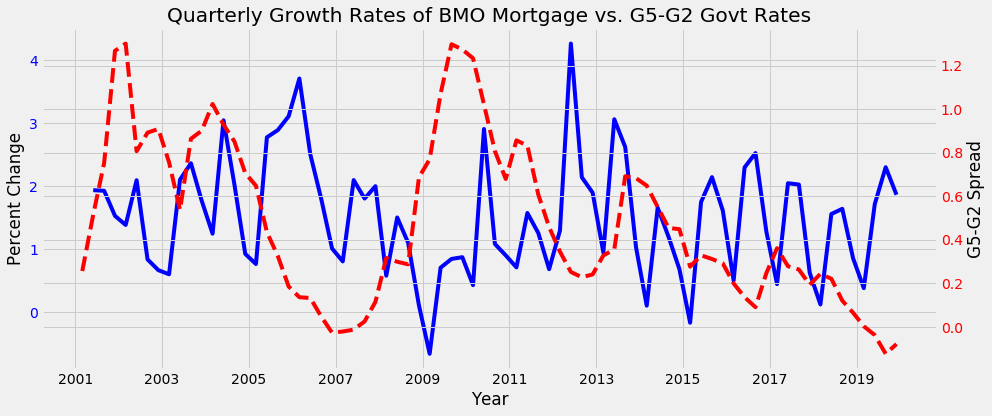

In [38]:
#G5_G2
plt_df = base_df[['BMO_Mort_growth', 'G5_G2', 'datetime']]

fig, ax1 = plt.subplots(1, 1, figsize=(14,6))

plt.style.use('fivethirtyeight')

color = 'b'
ax1.set_xlabel('Year')
ax1.set_ylabel('Percent Change')
ax1.plot('datetime', 'BMO_Mort_growth', data =plt_df, color = color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Quarterly Growth Rates of BMO Mortgage vs. G5-G2 Govt Rates')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'r'
ax2.set_ylabel('G5-G2 Spread')  # we already handled the x-label with ax1
ax2.plot('datetime','G5_G2','--',  color = color,   data =plt_df)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [39]:
def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )

In [40]:
#ist(base_df.columns)

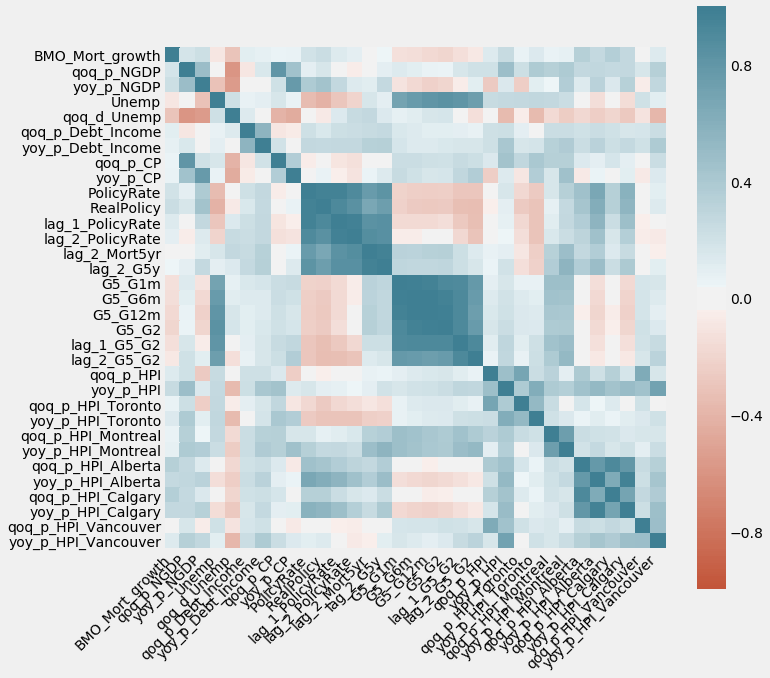

In [41]:
import seaborn as sns

corr_df = base_df[[ 'BMO_Mort_growth',
                'qoq_p_NGDP', 'yoy_p_NGDP',
                'Unemp',  'qoq_d_Unemp',
                'qoq_p_Debt_Income', 'yoy_p_Debt_Income',\
                'qoq_p_CP', 'yoy_p_CP',
                'PolicyRate', 'RealPolicy',
                'lag_1_PolicyRate', #'lag_1_RealPolicy',
                'lag_2_PolicyRate', #'lag_2_RealPolicy',
                #'qoq_d_PolicyRate', #'qoq_d_RealPolicy',
                'lag_2_Mort5yr',
                'lag_2_G5y', 
                # 'qoq_d_Mort5yr',\   'qoq_d_G5y',\
                'G5_G1m',\
                'G5_G6m', \
                'G5_G12m',\
                'G5_G2', 'lag_1_G5_G2', 'lag_2_G5_G2',\
                'qoq_p_HPI','yoy_p_HPI', \
                'qoq_p_HPI_Toronto','yoy_p_HPI_Toronto',\
                'qoq_p_HPI_Montreal','yoy_p_HPI_Montreal',\
                'qoq_p_HPI_Alberta','yoy_p_HPI_Alberta',\
                'qoq_p_HPI_Calgary','yoy_p_HPI_Calgary',\
                'qoq_p_HPI_Vancouver','yoy_p_HPI_Vancouver']]

corr = corr_df.corr()


plt.figure(figsize=(10, 10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

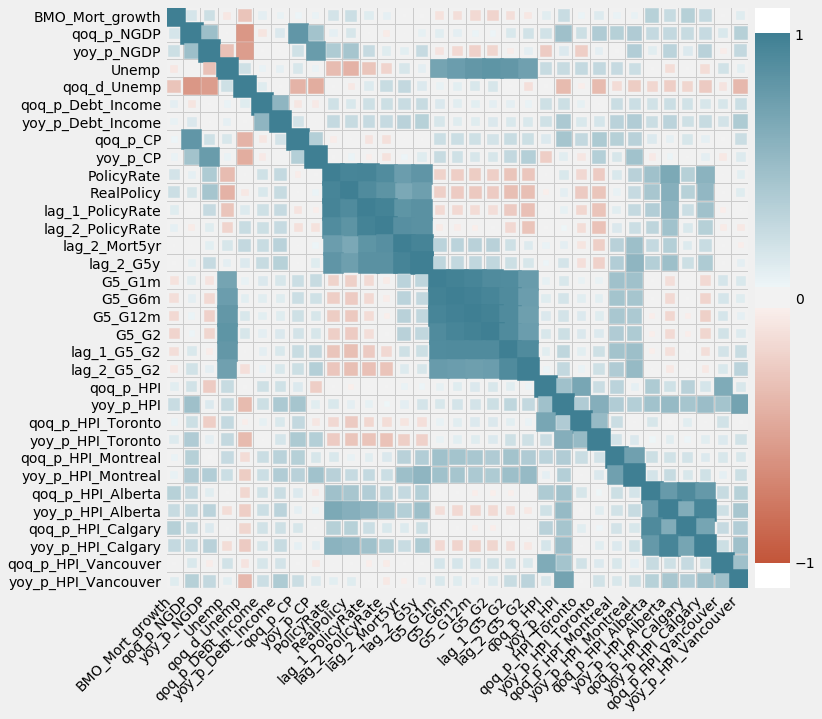

In [42]:
plt.figure(figsize=(10, 10))
corrplot(corr)

Tool Design

['Unemp', 'qoq_d_Unemp', 'qoq_p_HPI']


,base,adv,severe
Date,,,
2019-12-01,1.75,1.75,1.75
2020-03-01,1.50,0.00,0.00
2020-06-01,1.50,-0.25,-0.25
2020-09-01,1.50,-0.25,-1.25
2020-12-01,1.50,0.00,-0.80
2021-03-01,1.50,-0.75,-0.80
2021-06-01,1.50,0.40,-0.20
2021-09-01,1.50,0.40,0.15
2021-12-01,1.50,0.40,0.15


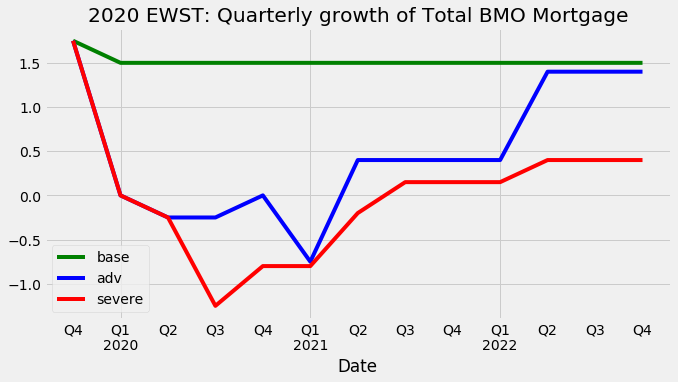

In [43]:
drivers = ['Unemp', 'qoq_d_Unemp','qoq_p_HPI']
print(drivers)

mydataset = dataiku.Dataset("Base")
base = mydataset.get_dataframe()
base['datetime'] = pd.to_datetime(base['Date'])

ba_df =  pd.merge(base, df, on='datetime', how='left')
adv_df =  pd.merge(adverse, df, on='datetime', how='left')
sev_df =  pd.merge(severe, df, on='datetime', how='left')

ba_df.index = ba_df['datetime']
adv_df.index = adv_df['datetime']
sev_df.index = sev_df['datetime']

b_proj=(ba_df[drivers]).truncate(before=pd.Timestamp('2019-11-01'),after=pd.Timestamp('2022-12-01'))
a_proj=(adv_df[drivers]).truncate(before=pd.Timestamp('2019-11-01'),after=pd.Timestamp('2022-12-01'))
s_proj=(sev_df[drivers]).truncate(before=pd.Timestamp('2019-11-01'),after=pd.Timestamp('2022-12-01'))

#first: unemp level
a_cut = 8.5
a_cut1 = 12

#second unemp change
b_cut1=0.1
b_cut2=0.4
b_cut3= 0.8

#third: hpi change
c_cut1=-0.03
c_cut2=0
c_cut3=0.02

#base
case1 = 0.25
case2 = 0.5
case3 = 1.5
case4 = 1.75

#adv1
case5= 0.0
case6= 0.1
case7= 0.15
case8= 0.175

#adv2
case9= -0.05
case10= 0.0 
case11= 0.05
case12= 0.1

#sev
case13= -0.25
case14= -0.15
case15= -0.125
case16= -0.075


#Unemp>Condition
#base
base_c = 0.1
case17 = case1 -base_c
case18 = case2 -base_c
case19 = case3 -base_c
case20 = case4 -base_c

#adv1
adv1_c = 0.2  #0.05
case21 = case5 -adv1_c
case22 = case6 -adv1_c
case23 = case7 -adv1_c
case24 = case8 -adv1_c 

#adv2
adv2_c = 0.75   #0.075
case25 = case9 -adv2_c
case26 = case10 -adv2_c
case27 = case11 -adv2_c
case28 = case12 -adv2_c

#sev
sev_c = 1  #0.15
case29 = case13 -sev_c
case30 = case14 -sev_c
case31 = case15 -sev_c
case32 = case16 -sev_c

#extremely high unemp
case33 = 0.0


def scenario_pred(senario_df,screened_var_lst):
  
    out=list()
    sece=senario_df[screened_var_lst]
    sece=sece.as_matrix()

    for i in sece: 
        # Unemp < Condition
        if   i[0] <= a_cut: 
            
            if i[1] <= b_cut1:
            
                if i[2] <= c_cut1:
                    out.append(case1)
                if c_cut1 < i[2] <= c_cut2:
                    out.append(case2)
                if c_cut2 < i[2] <= c_cut3:
                    out.append(case3)
                if c_cut3 < i[2]:
                    out.append(case4)
                
            if  i[1] > b_cut1 and i[1] <= b_cut2 :
            
                if i[2] <= c_cut1:
                    out.append(case5)
                if c_cut1 < i[2] <= c_cut2:
                    out.append(case6)
                if c_cut2 < i[2] <= c_cut3:
                    out.append(case7)
                if c_cut3 < i[2]:
                    out.append(case8)      

            if  i[1] > b_cut2 and i[1] <= b_cut3:

                if i[2] <= c_cut1:
                    out.append(case9)
                if c_cut1 < i[2] <= c_cut2:
                    out.append(case10)
                if c_cut2 < i[2] <= c_cut3:
                    out.append(case11)
                if c_cut3 < i[2]:
                    out.append(case12)

            if i[1] > b_cut3:

                if i[2] <= c_cut1:
                    out.append(case13)
                if c_cut1 < i[2] <= c_cut2:
                    out.append(case14)
                if c_cut2 < i[2] <= c_cut3:
                    out.append(case15)
                if c_cut3 < i[2]:
                    out.append(case16)
                
                
         # Unemp > Condition
        if   i[0] > a_cut and i[0] <= a_cut1:
            
            if i[1] <= b_cut1:
            
                if i[2] <= c_cut1:
                    out.append(case17)
                if c_cut1 < i[2] <= c_cut2:
                    out.append(case18)
                if c_cut2 < i[2] <= c_cut3:
                    out.append(case19)
                if c_cut3 < i[2]:
                    out.append(case20)

            if  i[1] > b_cut1 and i[1] <= b_cut2 :

                if i[2] <= c_cut1:
                    out.append(case21)
                if c_cut1 < i[2] <= c_cut2:
                    out.append(case22)
                if c_cut2 < i[2] <= c_cut3:
                    out.append(case23)
                if c_cut3 < i[2]:
                    out.append(case24)      

            if  i[1] > b_cut2 and i[1] <= b_cut3:

                if i[2] <= c_cut1:
                    out.append(case25)
                if c_cut1 < i[2] <= c_cut2:
                    out.append(case26)
                if c_cut2 < i[2] <= c_cut3:
                    out.append(case27)
                if c_cut3 < i[2]:
                    out.append(case28)

            if  i[1] > b_cut3:

                if i[2] <= c_cut1:
                    out.append(case29)
                if c_cut1 < i[2] <= c_cut2:
                    out.append(case30)
                if c_cut2 < i[2] <= c_cut3:
                    out.append(case31)
                if c_cut3 < i[2]:
                    out.append(case32)
                    
        if   i[0] > a_cut1:
            out.append(case33)
                
    out_pd=pd.Series(out)
    return out_pd

out_base=scenario_pred(b_proj,drivers)
out_adv=scenario_pred(a_proj,drivers)
out_severe=scenario_pred(s_proj,drivers)
pd_proj=pd.DataFrame()
pd_proj['base']=out_base.values
pd_proj['adv']=out_adv.values
pd_proj['severe']=out_severe.values

date=pd.Series()
date=date.append(b_proj.reset_index()['datetime'],ignore_index = True)
pd_proj['Date']=date

plt.figure
pd_proj.set_index('Date',inplace=True)
pd_proj.plot(color=['g','b','r'],figsize=(10,5),title='2020 EWST: Quarterly growth of Total BMO Mortgage')

pd_proj

0


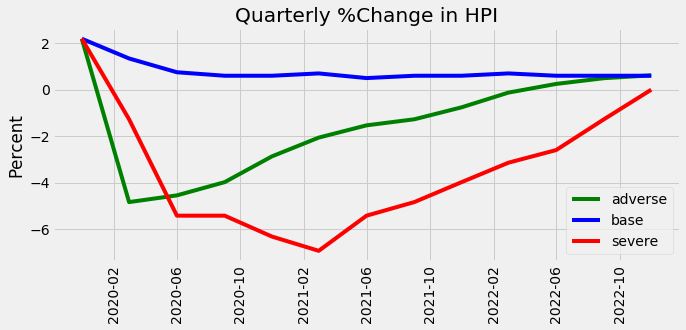

1


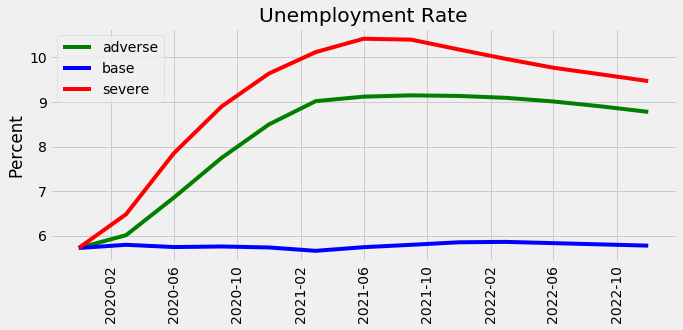

2


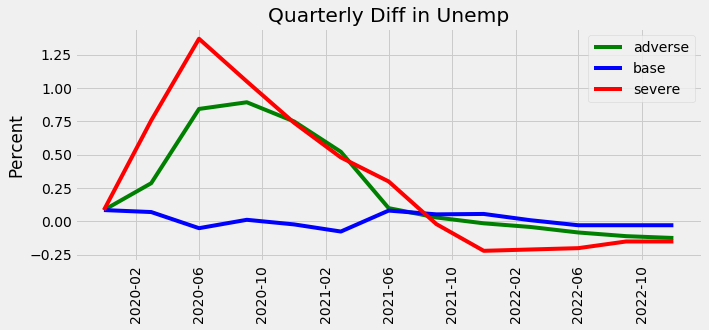

In [44]:
#scenario graphs
#driver1= tool_drivers[0]
#driver2= tool_drivers[1]

b_proj['scenario'] = 'base'  
a_proj['scenario'] = 'adverse'   
s_proj['scenario'] = 'severe'   
titles =['Quarterly %Change in HPI','Unemployment Rate', 'Quarterly Diff in Unemp'] 

# Combine all dataframes
scenario_df = pd.concat([b_proj,a_proj,s_proj])
scenario_df = scenario_df.reset_index()
scenario_df['Date'] =scenario_df['datetime'] 

warnings.filterwarnings("ignore")
#plots
for i in range(0, len(drivers)):
    print(i)
    fig, ax = plt.subplots(figsize=(10,4))
    ax.set_color_cycle(['g', 'b', 'r'])
    
    for key, grp in scenario_df.groupby(['scenario']):
        if 'Unemp' in drivers[i-1]:
            ax.plot( grp['Date'], grp[drivers[i-1]],  label=key)
        else: 
            ax.plot( grp['Date'], grp[drivers[i-1]]*100,  label=key)
    ax.legend()
    ax.set_title(titles[i])  #tool_drivers[i-1]
    plt.xticks(rotation=90)  
    plt.ylabel('Percent')
    plt.show()  

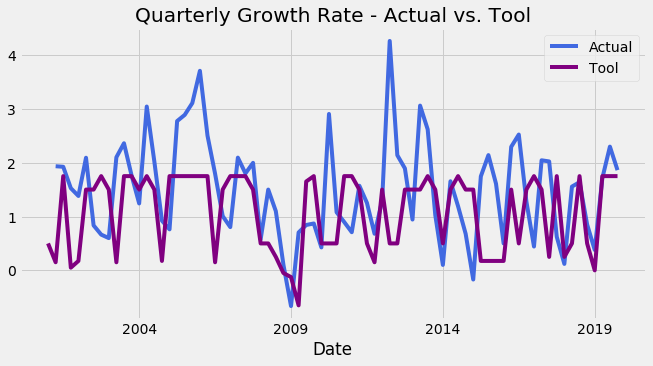

In [45]:
#Historical Fit
base.index = base['datetime']
b_his=(base[['Unemp','qoq_d_Unemp', 'qoq_p_HPI']]).truncate(before=pd.Timestamp('2001-03-01'),after=pd.Timestamp('2019-12-01'))
out_hist=scenario_pred(b_his,['Unemp','qoq_d_Unemp', 'qoq_p_HPI'])

pd_hist=pd.DataFrame()
pd_hist['Tool']=out_hist.values
pd_hist['Actual']=plt_df['BMO_Mort_growth'].values

date=pd.Series()
date=date.append(b_his.reset_index()['datetime'],ignore_index = True)


pd_hist['Date']=date
pd_hist.set_index('Date',inplace=True)

#join with scenario forecast
pd_hist['Unemp']=b_his['Unemp'].values
pd_hist['qoq_d_Unemp']=b_his['qoq_d_Unemp'].values
pd_hist['qoq_p_HPI']=b_his['qoq_p_HPI'].values*100

graph_pd = pd_hist[['Actual', 'Tool']]

plt.figure
graph_pd.plot(colors=['royalblue','purple'], figsize=(10,5),title='Quarterly Growth Rate - Actual vs. Tool')

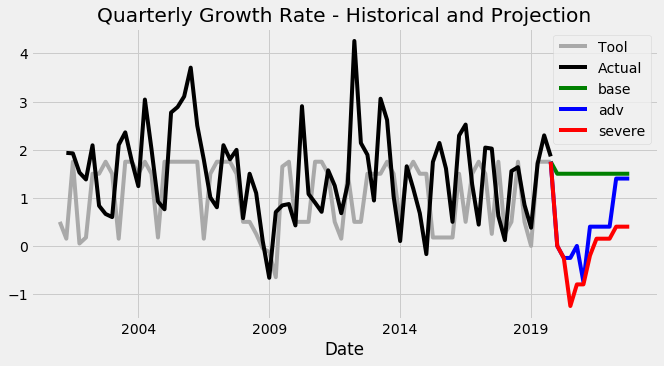

In [46]:
base.index = base['datetime']
b_his=(base[['Unemp','qoq_d_Unemp', 'qoq_p_HPI']]).truncate(before=pd.Timestamp('2001-03-01'),after=pd.Timestamp('2019-12-01'))
out_hist=scenario_pred(b_his,['Unemp','qoq_d_Unemp', 'qoq_p_HPI'])

pd_hist=pd.DataFrame()
pd_hist['Tool']=out_hist.values
pd_hist['Actual']=plt_df['BMO_Mort_growth'].values
date=pd.Series()
date=date.append(b_his.reset_index()['datetime'],ignore_index = True)

pd_hist['Date']=date
pd_hist.set_index('Date',inplace=True)

joined=pd_hist.join(pd_proj,how='outer')
plt.figure
joined.plot(color=['darkgrey','black','g','b','r'],figsize=(10,5),title='Quarterly Growth Rate - Historical and Projection')

#R-sq

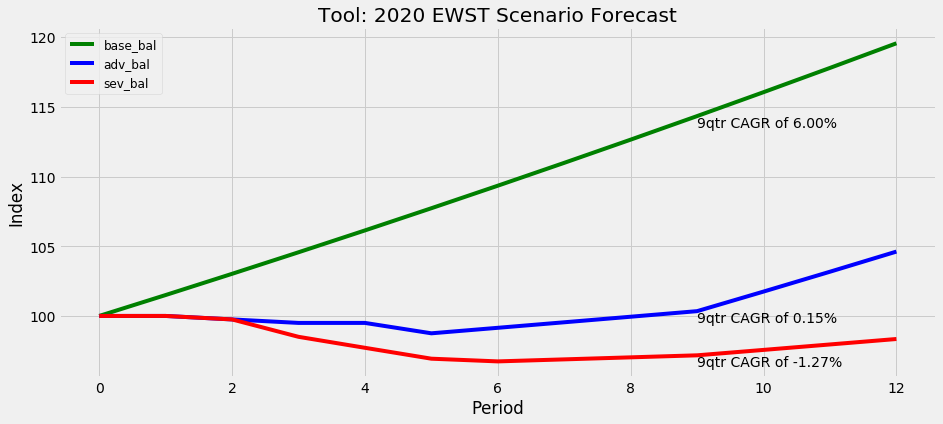

In [47]:
#change to balance
joined_trunk = joined.loc['2019-12-01': '2022-12-01']
joined_trunk['base_bal'] = np.where((joined_trunk.index=='2019-12-01'), 100,0)
joined_trunk['adv_bal'] = np.where((joined_trunk.index=='2019-12-01'), 100,0)
joined_trunk['sev_bal'] = np.where((joined_trunk.index=='2019-12-01'), 100,0)

new =joined_trunk.reset_index()

#base 
for i in range(1, len(new)):
    new.loc[i, 'base_bal'] = new.loc[i-1, 'base_bal'] *(1+ new.loc[i, 'base']/100) 
    
#adverse
for i in range(1, len(new)):
    new.loc[i, 'adv_bal'] = new.loc[i-1, 'adv_bal'] *(1+ new.loc[i, 'adv']/100) 
    
#sev adv    
for i in range(1, len(new)):
    new.loc[i, 'sev_bal'] = new.loc[i-1, 'sev_bal'] *(1+ new.loc[i, 'severe']/100)     
    
#calculate CAGR
b_end = new.loc[new.Date  =='2022-03-01', 'base_bal']
a_end = new.loc[new.Date  =='2022-03-01', 'adv_bal']
s_end = new.loc[new.Date  =='2022-03-01', 'sev_bal']


b_cagr = CAGR(100.0,b_end,9)*4
#print ('CAGR of {:.2%} '.format(b_cagr))
a_cagr = CAGR(100.0,a_end,9)*4
s_cagr = CAGR(100.0,s_end,9)*4

#Combined charts
plt.figure(figsize=(14,6))
plt.style.use('fivethirtyeight')

with pd.plot_params.use('x_compat', True):
    ax1=new['base_bal'].plot(color='g')
    ax2=new['adv_bal'].plot(style=['b-'])
    ax3=new['sev_bal'].plot(style=['r'])
    
ax1.set_xlabel('Period')
ax1.set_ylabel('Index')
ax1.set_title('Tool: 2020 EWST Scenario Forecast')


handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels,loc='upper left', prop={"size":12}) 

#show CARGs
ax1.text(9, b_end, '9qtr CAGR of {:.2%} '.format(b_cagr), fontsize=14, va='top')
ax2.text(9, a_end, '9qtr CAGR of {:.2%} '.format(a_cagr), fontsize=14, va='top')
ax3.text(9, s_end, '9qtr CAGR of {:.2%} '.format(s_cagr), fontsize=14, va='top')
plt.show()

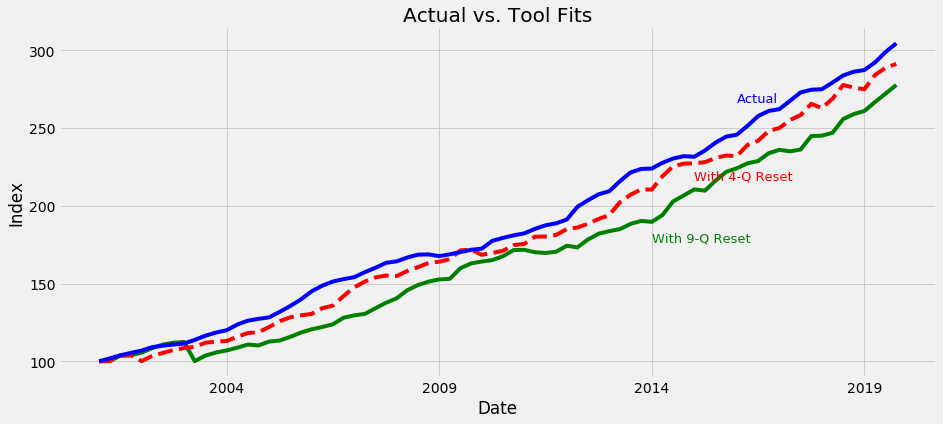

In [48]:
#change to balance and fit 
joined_bal = joined.loc['2001-03-01': '2019-12-01']
joined_bal['tool_bal_cumulative'] = np.where((joined_bal.index=='2001-03-01'), 100,0)
joined_bal['tool_bal_reset_4Q'] = np.where((joined_bal.index=='2001-03-01'), 100,0)
joined_bal['act_bal'] = np.where((joined_bal.index=='2001-03-01'), 100,0)

new =joined_bal.reset_index()
 
for i in range(1, len(new)):
    new.loc[i, 'act_bal'] = new.loc[i-1, 'act_bal'] *(1+ new.loc[i, 'Actual']/100) 
    
for i in range(1, len(new)):
    if i < 4:
        new.loc[i, 'tool_bal_reset_4Q'] = new.loc[i-1, 'act_bal'] *(1+ new.loc[i, 'Tool']/100) 
    else: 
        new.loc[i, 'tool_bal_reset_4Q'] = new.loc[i-4, 'act_bal'] *(1+ new.loc[i, 'Tool']/100) 

for i in range(1, len(new)):
    if i < 9:
        new.loc[i, 'tool_bal_reset_9Q'] = new.loc[i-1, 'act_bal'] *(1+ new.loc[i, 'Tool']/100) 
    else: 
        new.loc[i, 'tool_bal_reset_9Q'] = new.loc[i-9, 'act_bal'] *(1+ new.loc[i, 'Tool']/100) 

#for i in range(1, len(new)):
#    new.loc[i, 'tool_bal_cumulative'] = new.loc[i-1, 'tool_bal_cumulative'] *(1+ new.loc[i, 'Tool']/100)         
        
#make date to index
new['Date']=pd.to_datetime(new['Date'])
new.set_index('Date', inplace=True)
        
#Combined charts
plt.figure(figsize=(14,6))
plt.style.use('fivethirtyeight')

with pd.plot_params.use('x_compat', True):
    ax1=new['tool_bal_reset_9Q'].plot(color='g')
    ax2=new['tool_bal_reset_4Q'].plot(style=['r--'])
    ax3=new['act_bal'].plot(style=['b-'])

ax1.set_xlabel('Date')
ax1.set_ylabel('Index')
ax1.set_title('Actual vs. Tool Fits')

ax1.text('2016-01-01', 265, 'Actual', fontsize=13, color='b', va='bottom')
ax2.text('2015-01-01', 215, 'With 4-Q Reset', fontsize=13, color='r', va='bottom')
ax3.text('2014-01-01', 175, 'With 9-Q Reset', fontsize=13, color='g', va='bottom')

handles, labels = ax1.get_legend_handles_labels()
#ax1.legend(handles, labels,loc='upper left', prop={"size":12})  